## Load the Dataset

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


FILENAME = "dataset/train_dataset.csv"

#Prepare train data
df1 = pd.read_csv(FILENAME, sep=",", low_memory=False)

# Converte i valori in numeri, sostituendo quelli non validi con NaN
df1["src_bytes"] = pd.to_numeric(df1["src_bytes"], errors='coerce')

# feature to remove because it identifies the subject of the connection and are not relevant for the analysis
useless_features = ["ts", "src_ip", "dst_ip", "ssl_subject", "ssl_issuer", "dns_query", "http_uri", "http_user_agent"]
for feature in useless_features:
    df1 = df1.drop(feature, axis=1)

df1 = df1.dropna()

In [4]:
df1

,src_port,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,...,http_request_body_len,http_response_body_len,http_status_code,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,53972,10502,tcp,-,0.000000,0.0,0,OTH,0,0,...,0,0,0,-,-,-,-,-,0,normal
1,37513,53,udp,dns,0.163608,47.0,423,SF,0,1,...,0,0,0,-,-,-,-,-,0,normal
2,2077,2077,tcp,-,0.208218,0.0,0,S0,0,120,...,0,0,0,-,-,-,-,-,0,normal
3,53972,10502,tcp,-,0.000000,0.0,0,OTH,0,0,...,0,0,0,-,-,-,-,-,0,normal
4,1880,47979,tcp,-,0.000000,0.0,0,OTH,0,1,...,0,0,0,-,-,-,-,-,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616997,53116,53,udp,dns,0.044893,84.0,424,SF,0,2,...,0,0,0,-,-,-,-,-,1,mitm
616998,57669,53,udp,dns,0.002957,84.0,436,SF,0,2,...,0,0,0,-,-,-,-,-,1,mitm
616999,54730,53,udp,dns,0.016624,58.0,178,SF,0,2,...,0,0,0,-,-,-,-,-,1,mitm
617000,59846,443,tcp,ssl,48.271568,3219.0,1212,SF,0,26,...,0,0,0,-,-,-,-,-,1,mitm


/var/folders/j6/1lxb8g2n5l52sjcnr7jwm8yc0000gn/T/ipykernel_28456/1780556909.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/j6/1lxb8g2n5l52sjcnr7jwm8yc0000gn/T/ipykernel_28456/1780556909.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/j6/1lxb8g2n5l52sjcnr7jwm8yc0000gn/T/ipykernel_28456/1780556909.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/j6/1lxb8g2n5l52sjcnr7jwm8yc0000gn/T/ipykernel_28456/1780556909.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

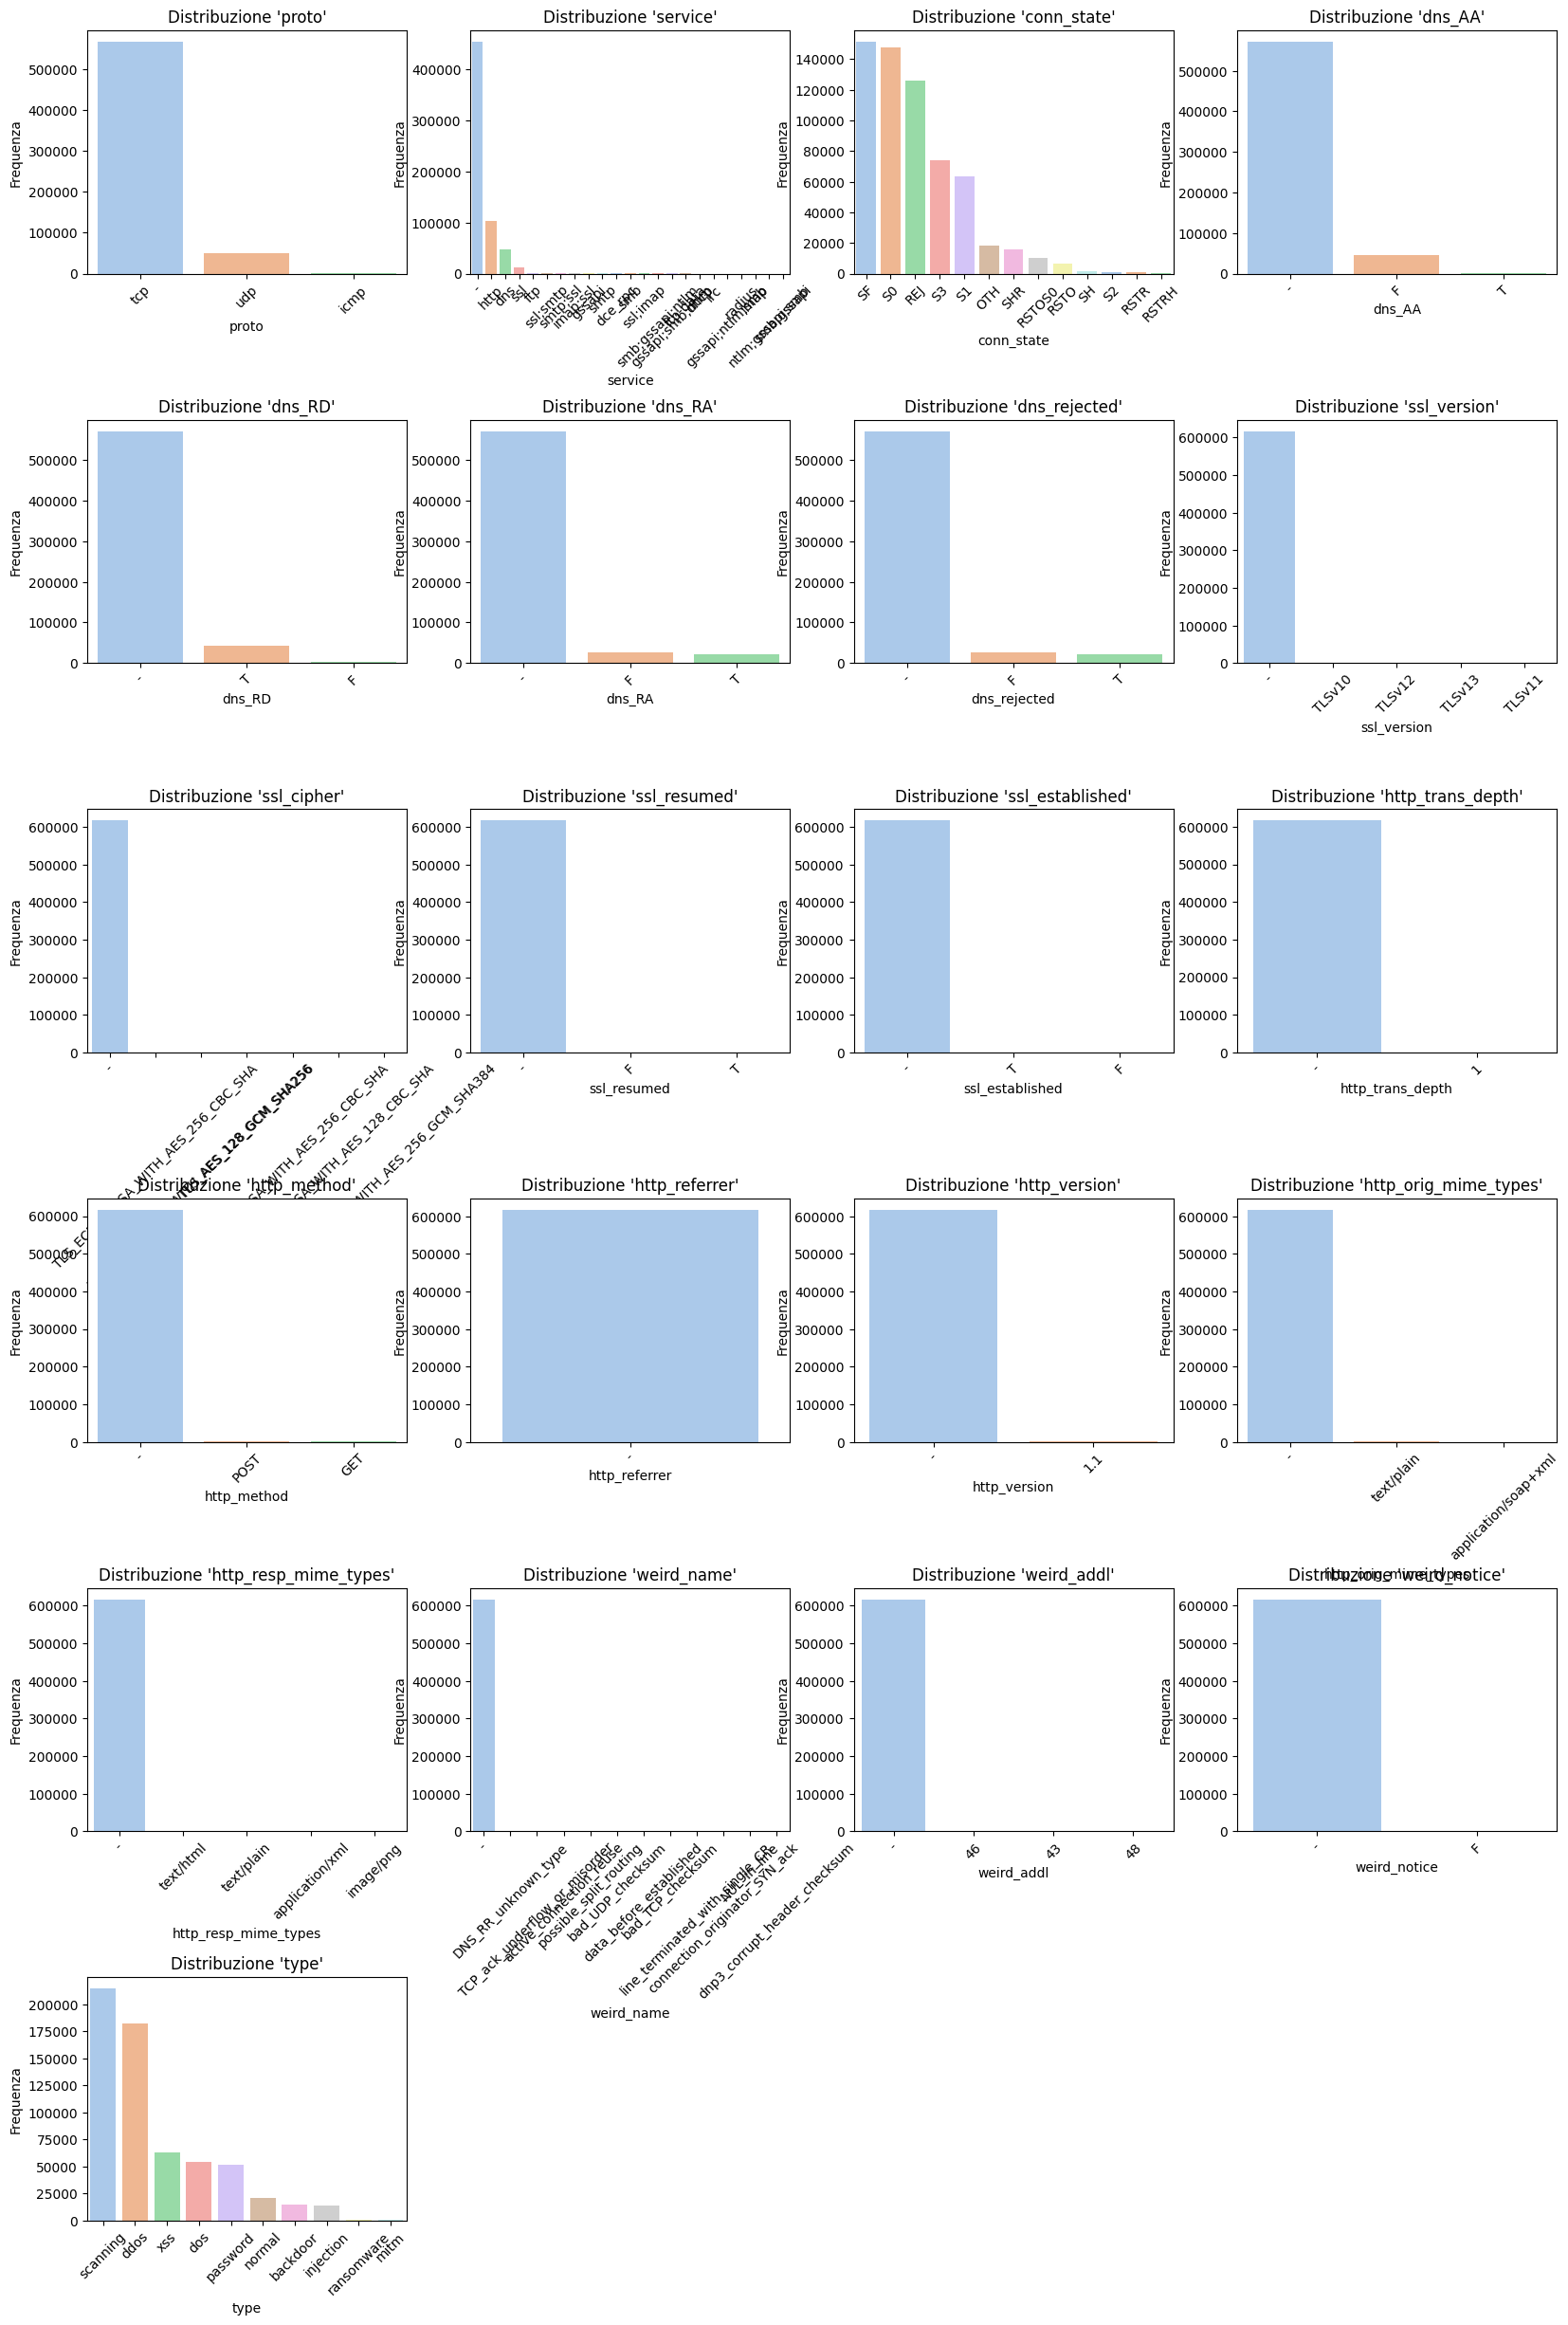

In [23]:
# get categorical columns
categorical_columns = df1.select_dtypes(include=["object"]).columns.tolist()

# Funzione per creare grafici
def plot_categorical_distribution(df, categorical_columns):
    num_columns = len(categorical_columns)
    ncols = 4  # Numero di grafici per riga
    nrows = int(np.ceil(num_columns / ncols))  # Calcola il numero di righe necessarie

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows), gridspec_kw={'hspace': 0.6})
    axes = axes.flatten()  # Rende l'array 2D di assi in un array 1D per iterazione

    for i, col in enumerate(categorical_columns):
        value_counts = df[col].value_counts()

        # Grafico a barre
        sns.barplot(
            x=value_counts.index, 
            y=value_counts.values, 
            ax=axes[i], 
            palette="pastel"
        )
        axes[i].set_title(f"Distribuzione '{col}'")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequenza")
        axes[i].tick_params(axis='x', rotation=45)

    # Rimuovi eventuali assi vuoti
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Esegui la funzione
plot_categorical_distribution(df1, categorical_columns)


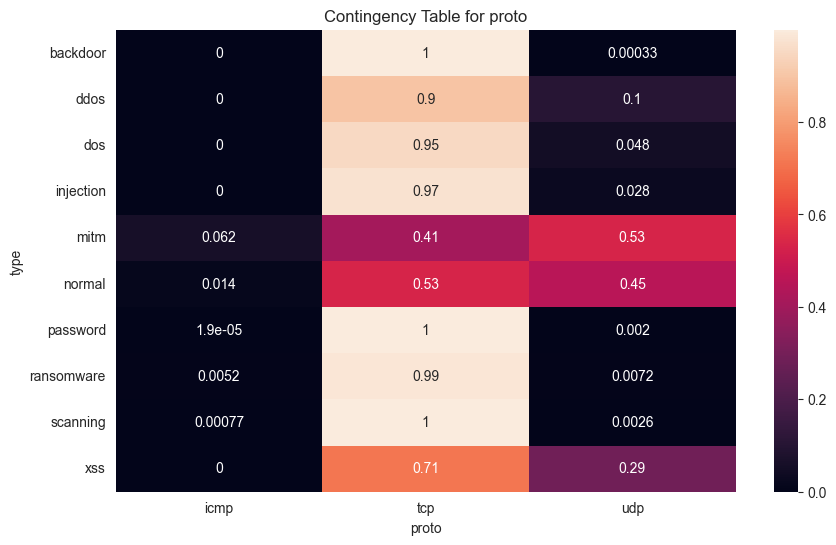

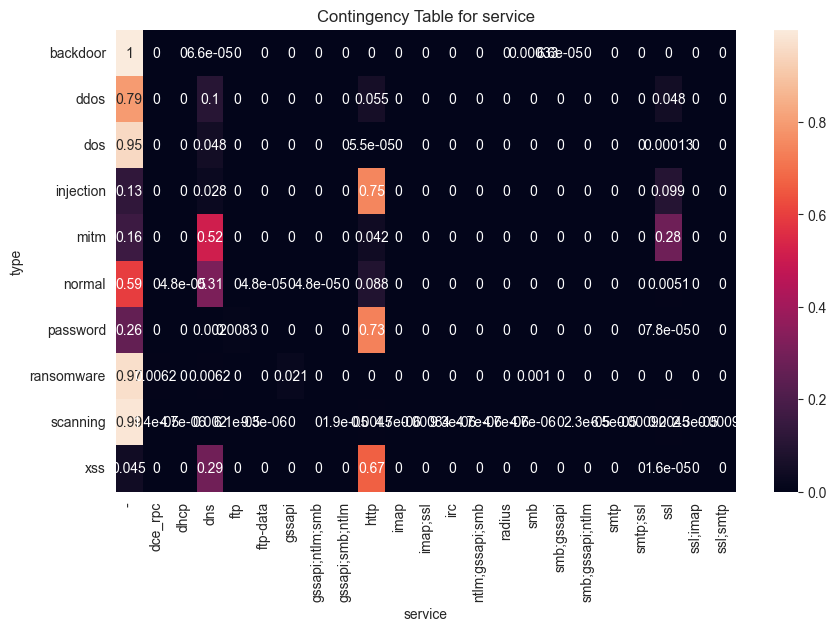

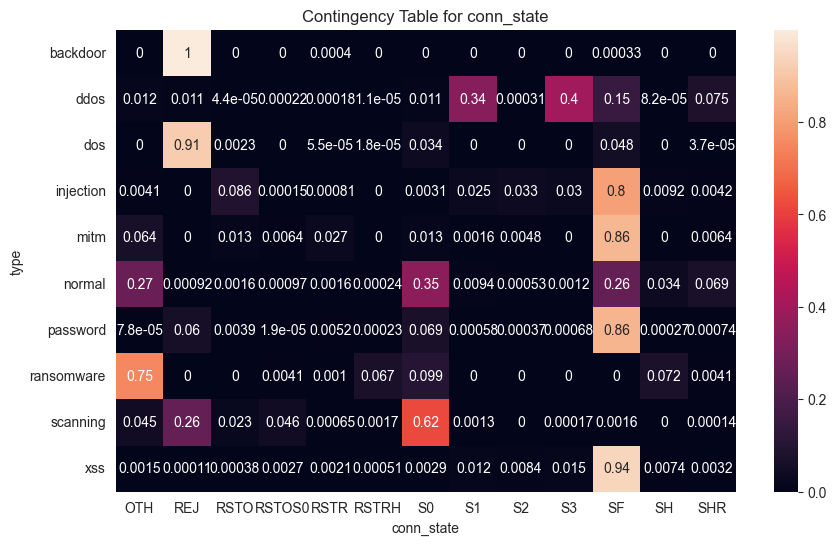

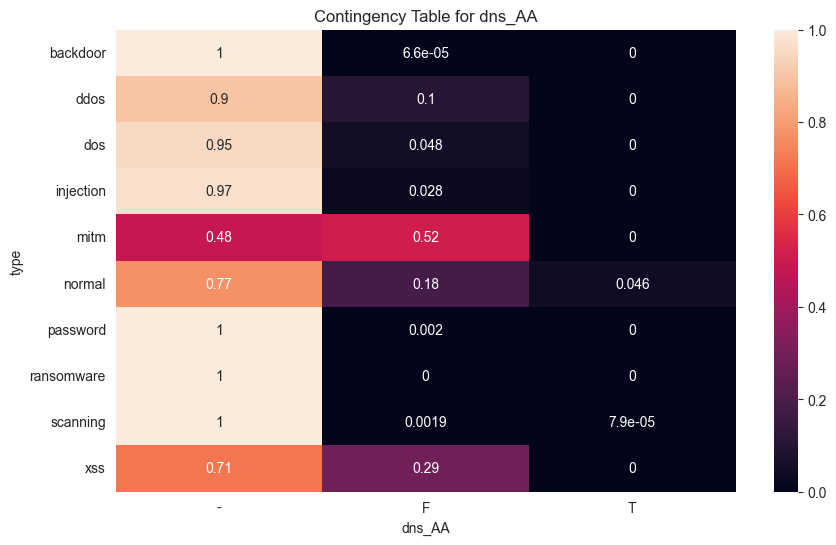

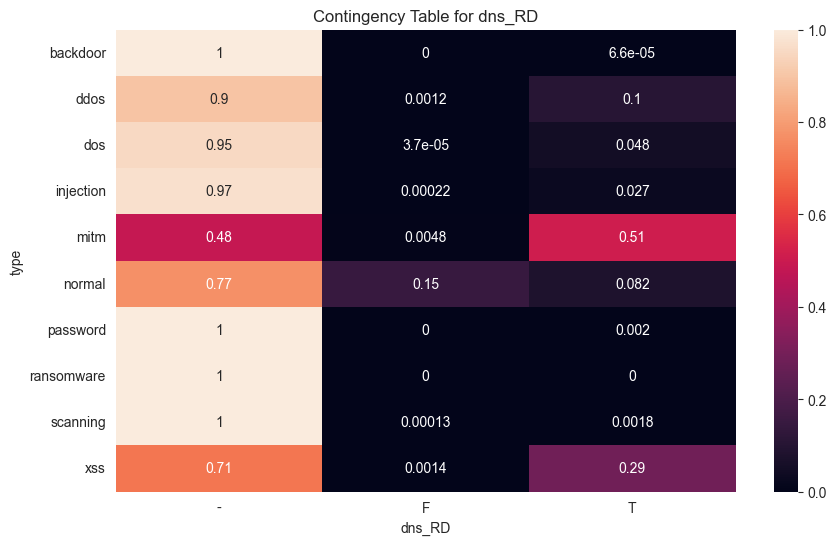

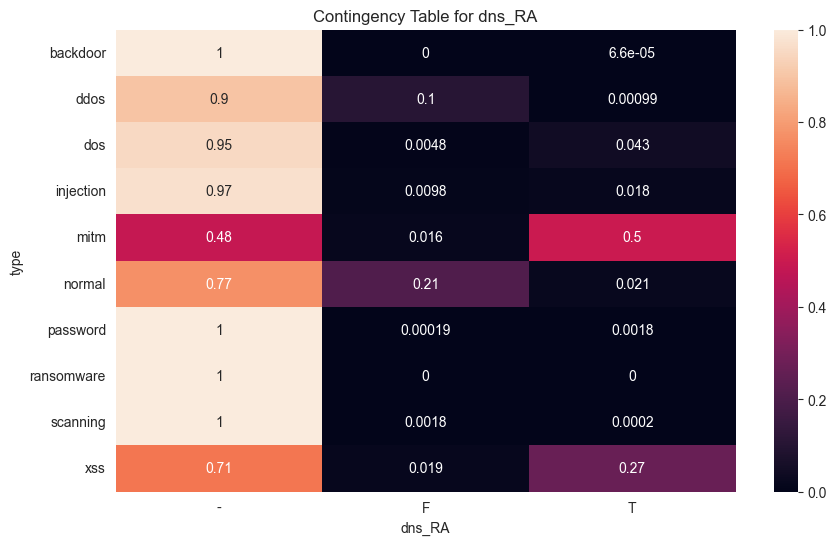

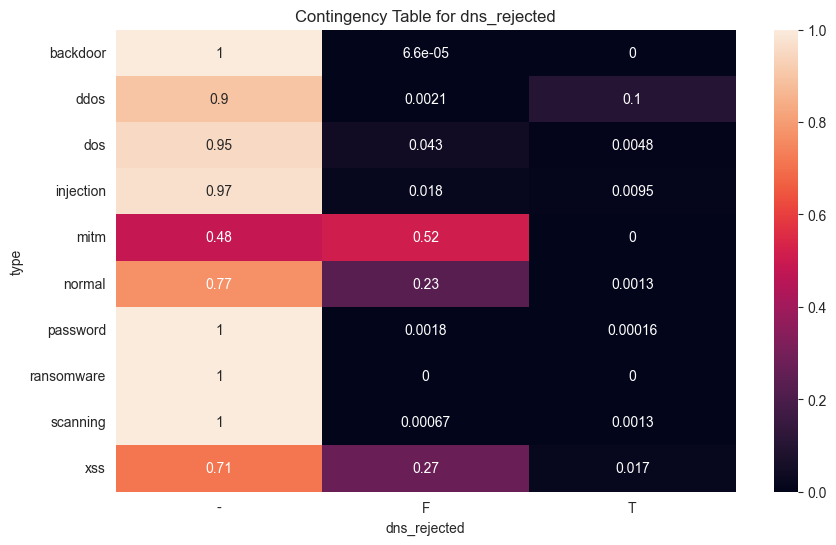

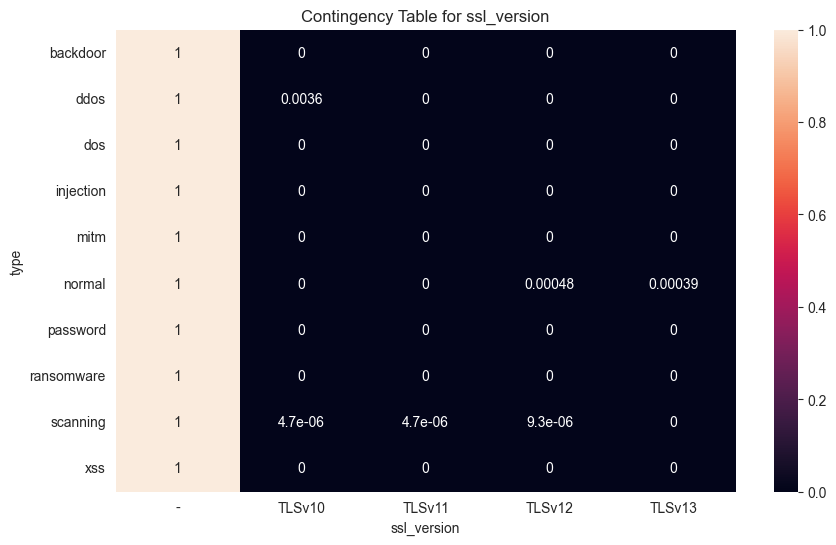

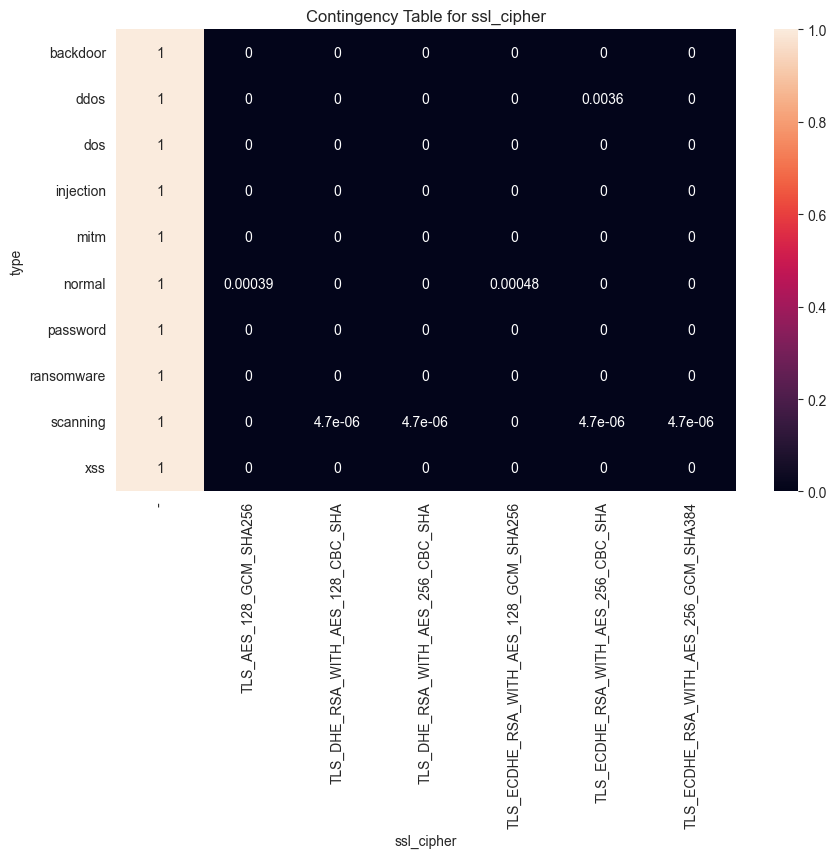

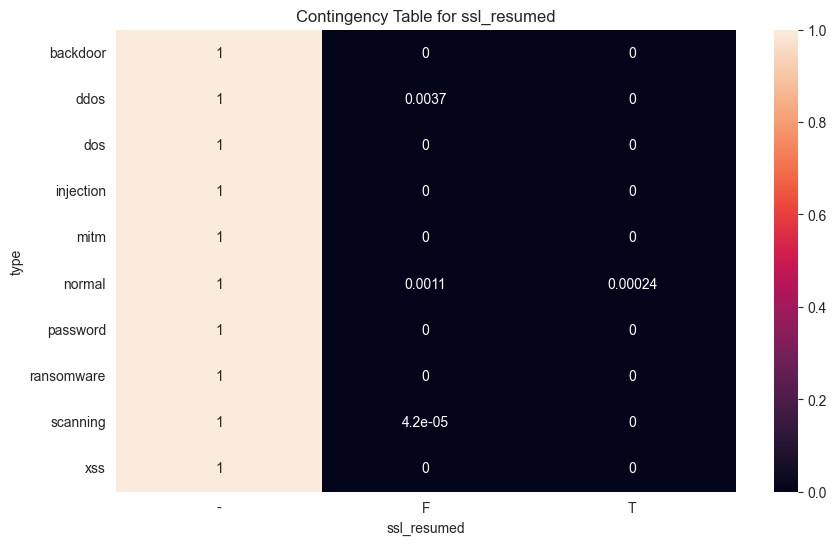

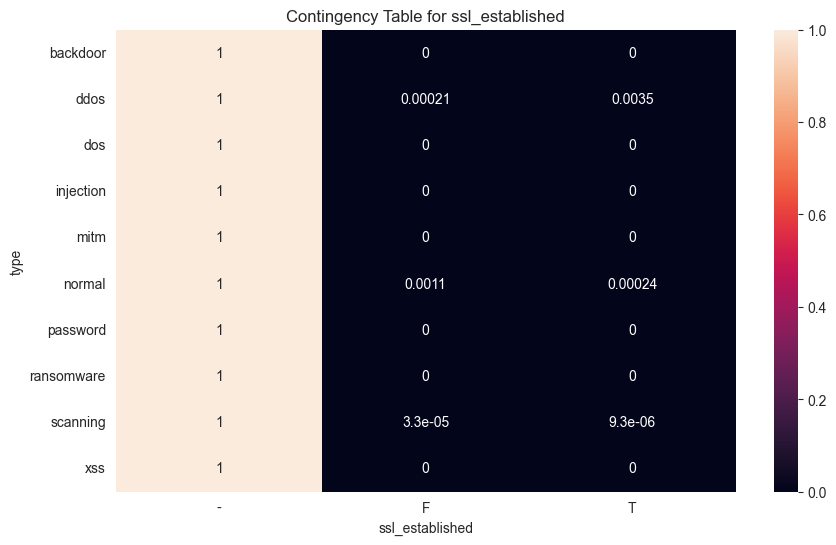

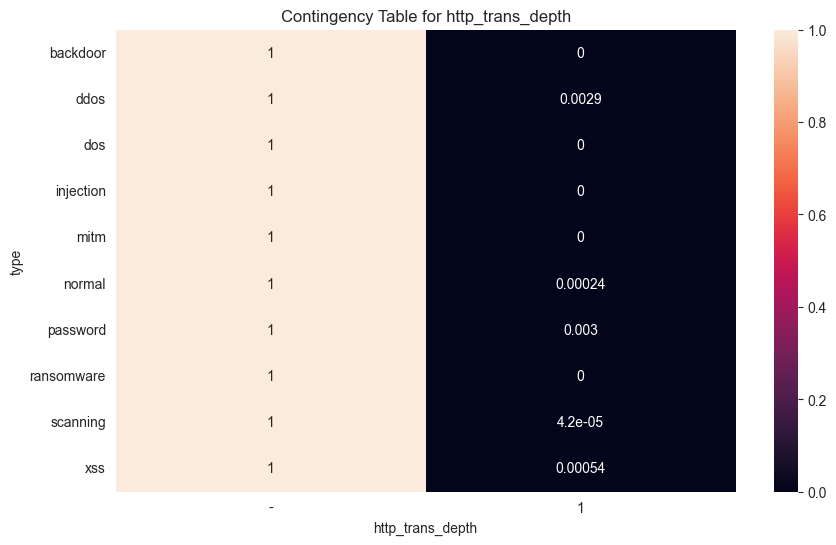

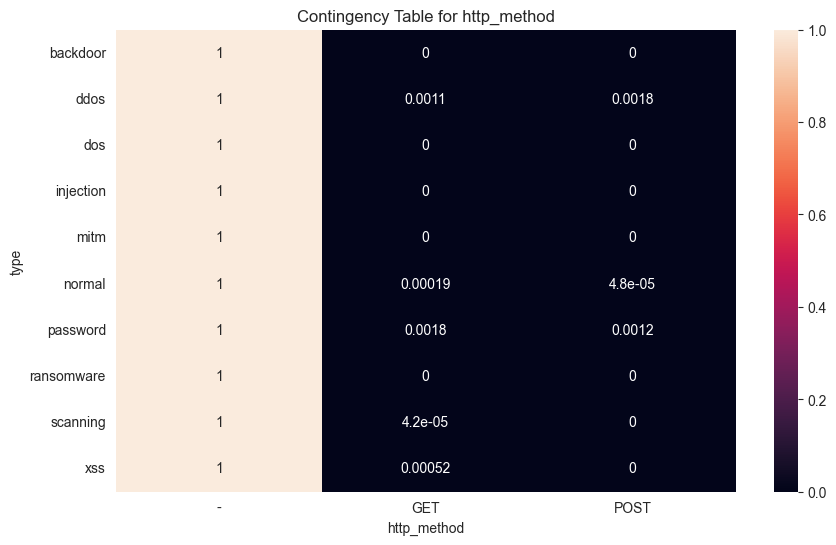

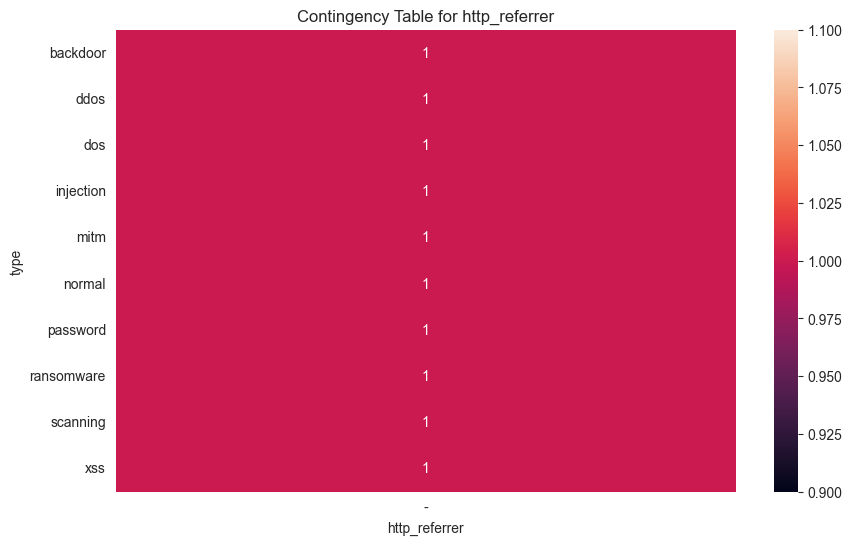

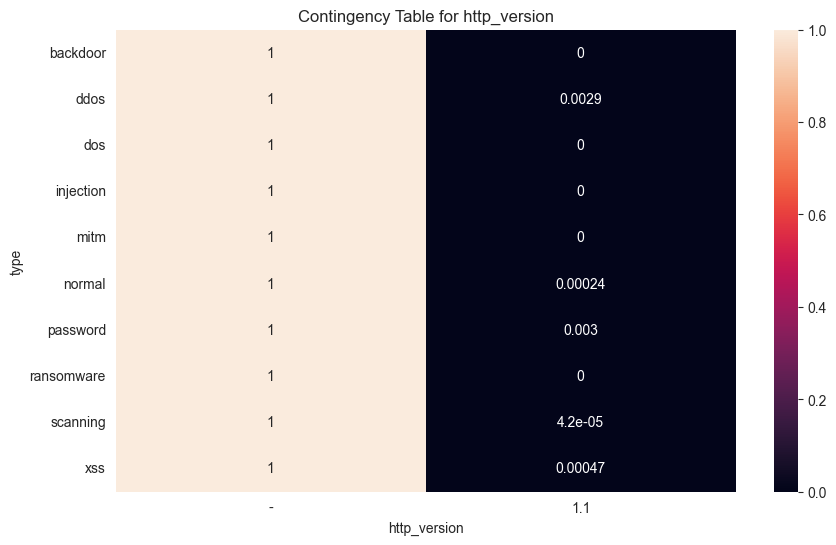

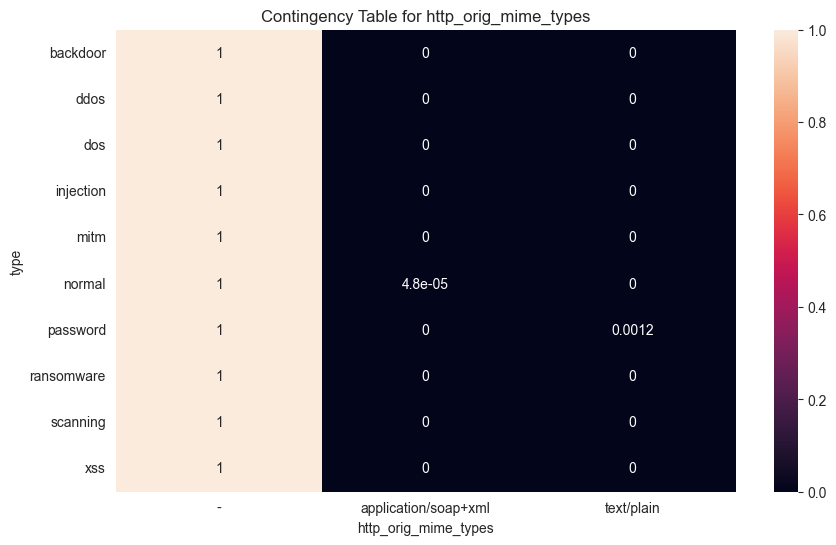

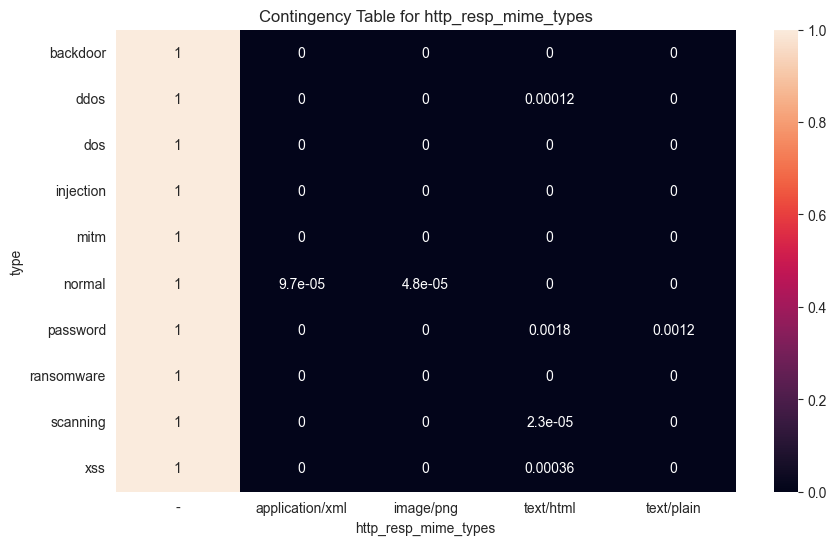

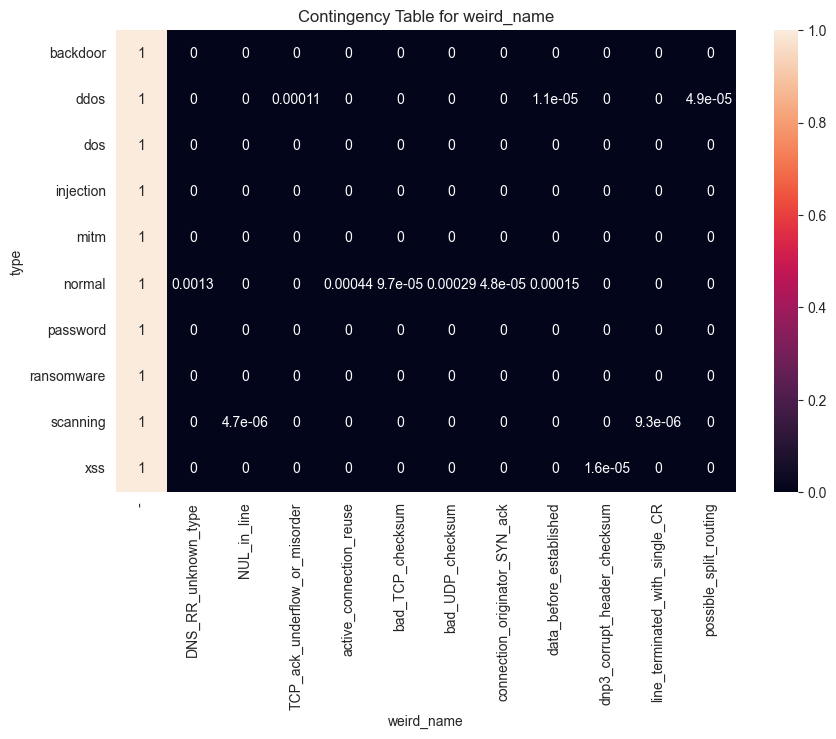

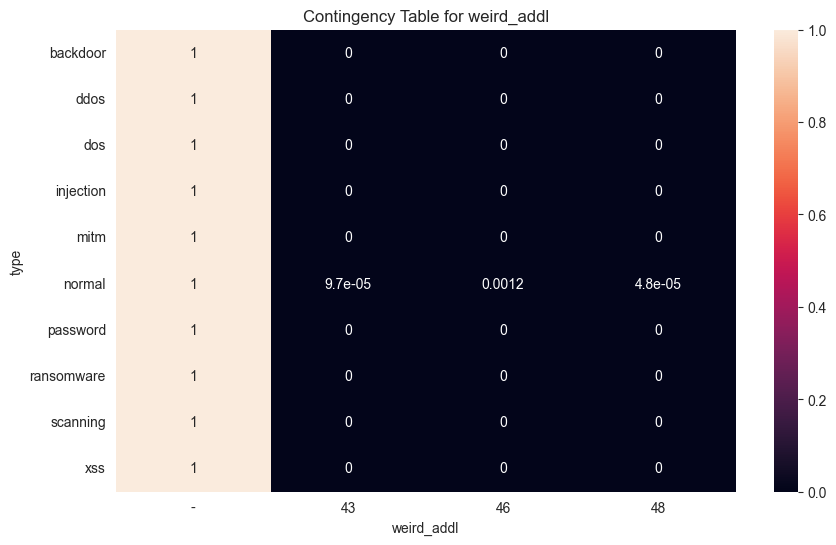

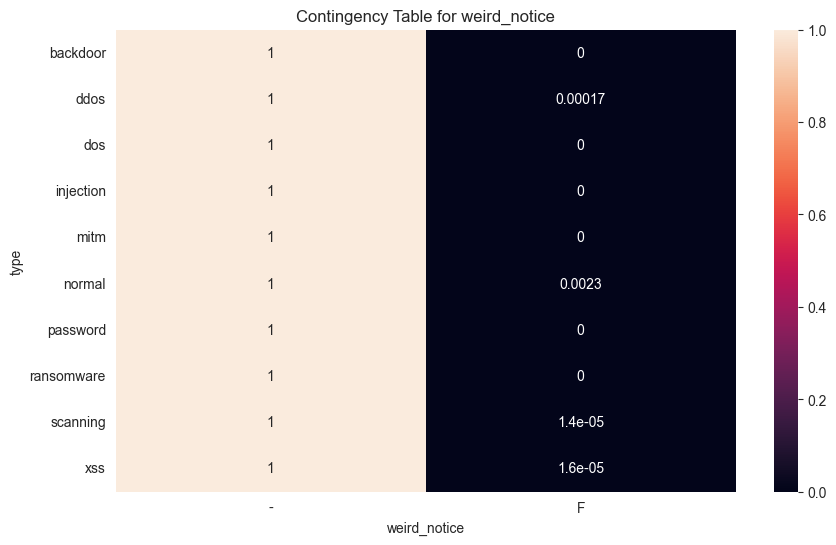

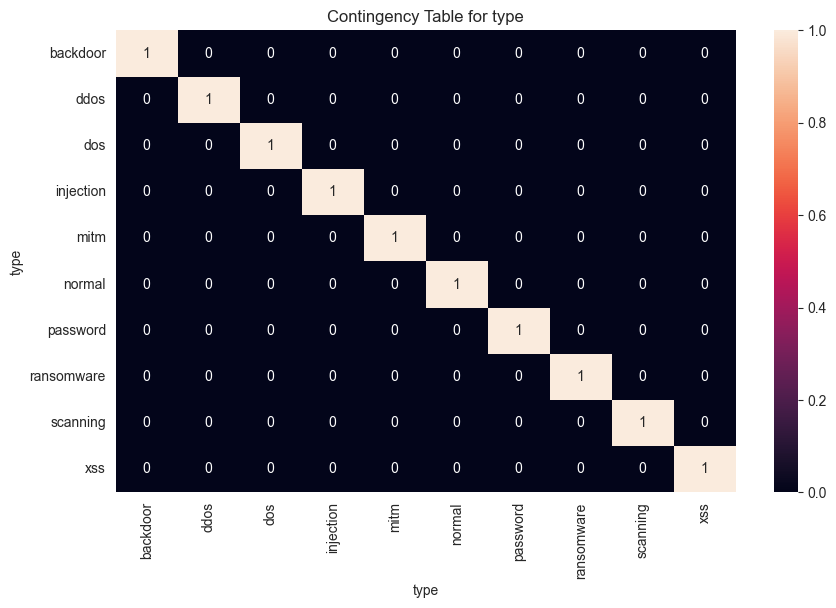

In [6]:
# get categorical columns
categorical_columns = df1.select_dtypes(include=["object"]).columns.tolist()

# contingency table
for column in categorical_columns:
    contingency_table = pd.crosstab(df1["type"], df1[column],)
    percent_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)
    plt.figure(figsize=(10, 6))
    sns.heatmap(percent_table, annot=True)
    plt.title(f"Contingency Table for {column}")
    plt.show()

    percent_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)

# plot the correlation matrix
# sns.heatmap(df1.corr(), annot=True)

# # plot the distribution of each column
# for column in df1.columns:
#     plt.figure(figsize=(10, 6))
#     sns.histplot(df1[column])
#     plt.title(column)
#     plt.show()
